# Problem 3

In this Jupyter notebook, we visualize how boosting and AdaBoost work. 

Use this notebook to write your code for problem 3.

In [34]:
# Setup.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from IPython.display import HTML

import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/sets/set3/boosting_helper.py', 'boosting_helper.py')

from boosting_helper import (
    generate_dataset,
    visualize_dataset,
    gb_suite, ab_suite,
    visualize_loss_curves_gb, visualize_loss_curves_ab,
    animate_gb, animate_ab
)

## Dataset

We'll start off by generating a complex, slightly noisy 2-dimensional dataset (namely, two spirals) with +1 or -1 as labels. Note that learning on this dataset is a classification problem.

(Note: red indicates positive and blue indicates negative.)

<Figure size 432x288 with 0 Axes>

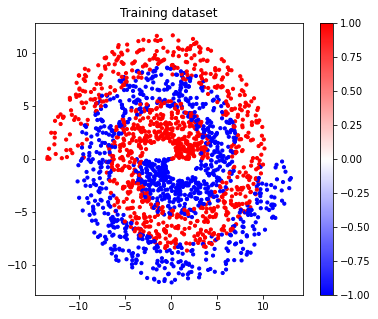

<Figure size 432x288 with 0 Axes>

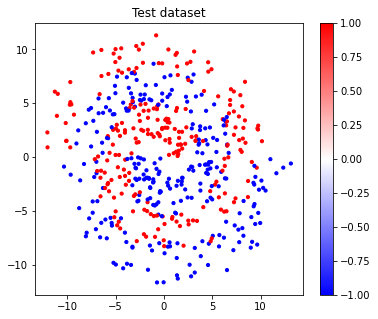

In [35]:
# Generate a dataset with 2000 training points and 500 test points.
# Refer to the source code for more details.
(X_train, Y_train), (X_test, Y_test) = generate_dataset(2000, 500, 1.5, 4.0)

# Visualize the generated dataset.
visualize_dataset(X_train, Y_train, 'Training dataset')
visualize_dataset(X_test, Y_test, 'Test dataset')

## Gradient Boosting

Let's implement a simple gradient boosting model to classify this dataset. Since we are implementing gradient boosting, we will need to use regressors even though we are dealing with a classification problem. To resolve this issue, we can simply take the sign of the predictions as the predictions of the classifier.

Our weak regressors will be decision trees with a maximum of `n_nodes=4` leaf nodes. You can use the following line to create a DT weak regressor:

`clf = DecisionTreeRegressor(max_leaf_nodes=n_nodes)`

Fill in the `fit()` method in the cell below.

In [36]:
class GradientBoosting():
    def __init__(self, n_clfs=100):
        '''
        Initialize the gradient boosting model.

        Inputs:
            n_clfs (default 100): Initializer for self.n_clfs.        
                
        Attributes:
            self.n_clfs: The number of DT weak regressors.
            self.clfs: A list of the DT weak regressors, initialized as empty.
        '''
        self.n_clfs = n_clfs
        self.clfs = []
        
    def fit(self, X, Y, n_nodes=4):
        '''
        Fit the gradient boosting model. Note that since we are implementing this method in a class,
        rather than having a bunch of inputs and outputs, you will deal with the attributes of the class.
        (see the __init__() method).
        
        This method should thus train self.n_clfs DT weak regressors and store them in self.clfs.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            Y: A (N, ) shaped numpy array containing the (float) labels of the data points.
               (Even though the labels are ints, we treat them as floats.)
            n_nodes: The max number of nodes that the DT weak regressors are allowed to have.
        '''
    #==============================================
    # TODO: implement the fit function.
    #==============================================
        predictions = np.zeros(len(Y))   
        for _ in range(self.n_clfs):
            clf = DecisionTreeRegressor(max_leaf_nodes=n_nodes)
            clf.fit(X, Y - predictions)
            self.clfs.append(clf)
            predictions += clf.predict(X)

    def predict(self, X):
        '''
        Predict on the given dataset.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.

        Outputs:
            A (N, ) shaped numpy array containing the (float) labels of the data points.
            (Even though the labels are ints, we treat them as floats.)
        '''
        # Initialize predictions.
        Y_pred = np.zeros(len(X))
        
        # Add predictions from each DT weak regressor.
        # We choose step size / weight 1 for each weak regressor for simplicity.
        for clf in self.clfs:
            Y_curr = clf.predict(X)
            Y_pred += Y_curr # this means we choose the step size / weight to be 1

        # Return the sign of the predictions.
        return np.sign(Y_pred)

    def loss(self, X, Y):
        '''
        Calculate the classification loss.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            Y: A (N, ) shaped numpy array containing the (float) labels of the data points.
               (Even though the labels are ints, we treat them as floats.)
            
        Outputs:
            The classification loss.
        '''
        # Calculate the points where the predictions and the ground truths don't match.
        Y_pred = self.predict(X)
        misclassified = np.where(Y_pred != Y)[0]

        # Return the fraction of such points.
        return float(len(misclassified)) / len(X)

Let's plot the prediction results with 500 weak regressors. Note that misclassified points are marked in black.

<Figure size 432x288 with 0 Axes>

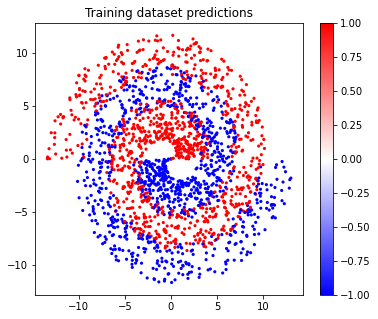

Training loss: 0.000000


<Figure size 432x288 with 0 Axes>

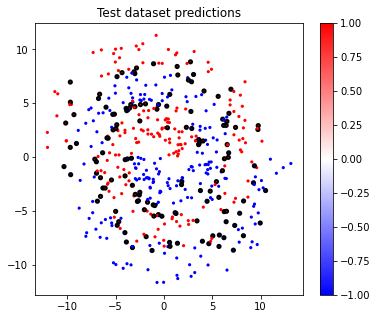

Test loss: 0.264000


In [37]:
model = gb_suite(GradientBoosting, 500, X_train, Y_train, X_test, Y_test)

## Visualization of Gradient Boosting Training

Let's visualize the training process of the gradient boosting model. First, we visualize how the predictions change with each new weak regressor that we train and add:


Animating...


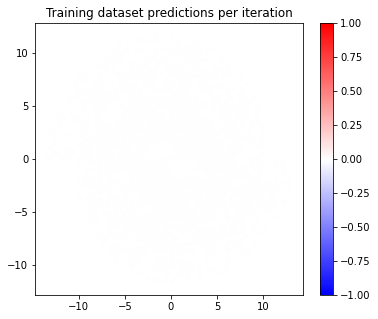

In [38]:
anim = animate_gb(model, X_train, Y_train, 'Training dataset predictions per iteration')
HTML(anim.to_html5_video())

Now, we visualize how the loss decreases with each new weak regressor:

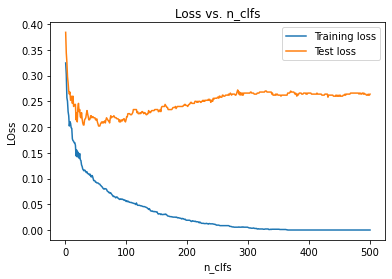

In [39]:
visualize_loss_curves_gb(model, X_train, Y_train, X_test, Y_test)

## AdaBoost

We used regression above for a classification problem. A better approach would be to use AdaBoost, which is a natural adaptation for classification.

Let's implement an AdaBoost model to classify this dataset. This time, our weak classifiers (not regressors!) will be decision trees with a maximum of `n_nodes=4` leaf nodes. You can use the following line to create a DT weak classifier:

`clf = DecisionTreeClassifier(max_leaf_nodes=n_nodes)`

Fill in the fit() method in the cell below.

**NOTE: Use the 0/1 loss here instead of the exponential loss!**

In [40]:
class AdaBoost():
    def __init__(self, n_clfs=100):
        '''
        Initialize the AdaBoost model.

        Inputs:
            n_clfs (default 100): Initializer for self.n_clfs.        
                
        Attributes:
            self.n_clfs: The number of DT weak classifiers.
            self.coefs: A list of the AdaBoost coefficients.
            self.clfs: A list of the DT weak classifiers, initialized as empty.
        '''
        self.n_clfs = n_clfs
        self.coefs = []
        self.clfs = []

    def fit(self, X, Y, n_nodes=4):
        '''
        Fit the AdaBoost model. Note that since we are implementing this method in a class, rather
        than having a bunch of inputs and outputs, you will deal with the attributes of the class.
        (see the __init__() method).
        
        This method should thus train self.n_clfs DT weak classifiers and store them in self.clfs,
        with their coefficients in self.coefs.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            Y: A (N, ) shaped numpy array containing the (float) labels of the data points.
               (Even though the labels are ints, we treat them as floats.)
            n_nodes: The max number of nodes that the DT weak classifiers are allowed to have.
            
        Outputs:
            A (N, T) shaped numpy array, where T is the number of iterations / DT weak classifiers,
            such that the t^th column contains D_{t+1} (the dataset weights at iteration t+1).
        '''
    #==============================================
    # TODO: implement the fit function.
    #==============================================
        N = len(Y)
        T = self.n_clfs
        A = np.zeros((N, T))
        D = np.ones(N) / N
        for t in range(T):
            clf = DecisionTreeClassifier(max_leaf_nodes=n_nodes)
            clf.fit(X, Y, sample_weight = D)
            self.clfs.append(clf)

            predictions = clf.predict(X)
            loss = 0
            for i in range(N):
                if predictions[i] != Y[i]:
                    loss += D[i]
            
            alpha = 0.5 * np.log((1 - loss) / loss)
            self.coefs.append(alpha)
            Z = (1 - loss) * np.exp(-alpha) + loss * np.exp(alpha)
            for i in range(N):
                D[i] *= np.exp(-alpha * Y[i] * predictions[i]) / Z
            A[:,t] = D
        return A
    
    def predict(self, X):
        '''
        Predict on the given dataset.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            
        Outputs:
            A (N, ) shaped numpy array containing the (float) labels of the data points.
            (Even though the labels are ints, we treat them as floats.)
        '''
        # Initialize predictions.
        Y_pred = np.zeros(len(X))
        
        # Add predictions from each DT weak classifier.
        for i, clf in enumerate(self.clfs):
            Y_curr = self.coefs[i] * clf.predict(X)
            Y_pred += Y_curr

        # Return the sign of the predictions.
        return np.sign(Y_pred)

    def loss(self, X, Y):
        '''
        Calculate the classification loss.

        Inputs:
            X: A (N, D) shaped numpy array containing the data points.
            Y: A (N, ) shaped numpy array containing the (float) labels of the data points.
               (Even though the labels are ints, we treat them as floats.)
            
        Outputs:
            The classification loss.
        '''
        # Calculate the points where the predictions and the ground truths don't match.
        Y_pred = self.predict(X)
        misclassified = np.where(Y_pred != Y)[0]

        # Return the fraction of such points.
        return float(len(misclassified)) / len(X)

Again, let's plot the prediction results with 500 weak classifiers (misclassified points marked in black).

<Figure size 432x288 with 0 Axes>

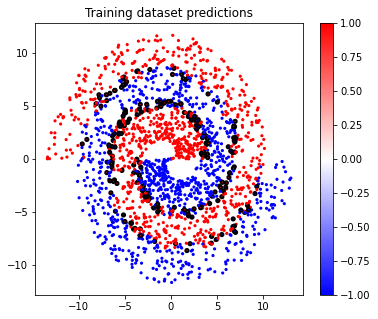

Training loss: 0.104500


<Figure size 432x288 with 0 Axes>

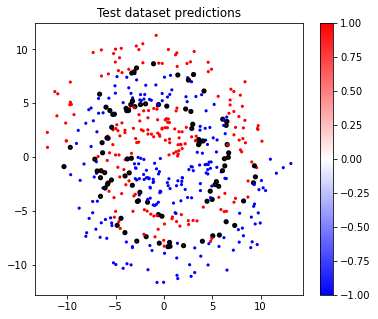

Test loss: 0.186000


In [41]:
model, D = ab_suite(AdaBoost, 500, X_train, Y_train, X_test, Y_test)

## Visualization of AdaBoost Training

Let's now visualize the training process of the AdaBoost model. First, we visualize how the predictions, as well as the dataset weights, change with each new weak classifier that we train and add:


Animating...


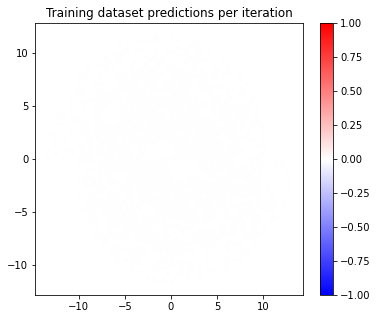

In [42]:
anim = animate_ab(model, X_train, Y_train, D, 'Training dataset predictions per iteration')
HTML(anim.to_html5_video())

Now, we visualize how the loss decreases with each new weak classifier:

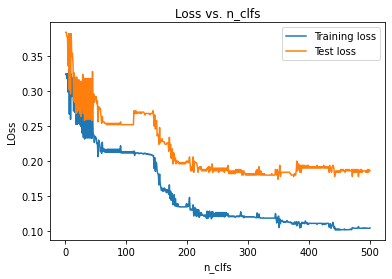

In [43]:
visualize_loss_curves_ab(model, X_train, Y_train, X_test, Y_test)